<a href="https://colab.research.google.com/github/piyushgoel997/MutationClassification/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import statements and declaring some global variables


In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.utils import plot_model
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.utils import shuffle
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv1D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

data_url = "https://raw.githubusercontent.com/piyushgoel997/MutationClassification/master/data.csv"
epochs = 100
batch_size = 8192

# to stop the model from overfitting on the training data.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=2, mode="min", restore_best_weights=True)

Using TensorFlow backend.


Load and represent data in a one-hot encoded matrix form to be easily able to train the model.

Matrix Dimentions: Number of examples, Number of Features (in this case, the length of the sequence of Amino Acids), Number of possible feature values (20 possible Amino Acids)

In [2]:
def get_aa_encoder():
    """
    One-hot encoding indices for the 20 possible amino acids.
    :return: the dictionary mapping amino acid to index in the one-hot encoding.
    """
    acids = "ARNDCEQGHILKMFPSTWYV"
    indices = {}
    i = 0
    for a in acids:
        indices[a] = i
        i += 1
    return indices


def make_matrix(seq, alt):
    """
    makes a matrix where each of the 51 features correspond to the amino acid at
    that position in the sequence after the one-hot encoding using the indices
    provided. Also puts a -1 at in the middle most feature at the position
    corresponding to the alt amino acid.
    :param seq: the sequence to be encoded.
    :param alt: the alternate amino acid
    :return: the resultant encoded matrix (51 X 20)
    """
    indices = get_aa_encoder()
    matrix = np.zeros((len(indices), len(seq)))
    i = 0
    for s in seq:
        matrix[indices[s]][i] = 1
        i += 1
    matrix[indices[alt]][int(len(seq) / 2)] = -1
    return matrix.T


def map_description(description):
    map = {'Benign': 0, 'Benign/Likely benign': 0, 'Likely benign': 0,
           'Likely pathogenic': 1, 'Pathogenic': 1, 'Pathogenic/Likely pathogenic': 1}
    return map[description]


X = []
Y = []
mutations = pd.read_csv(data_url)

for _, row in mutations.iterrows():
    X.append(make_matrix(row["REF_SEQ"], row["ALT_AA"]))
    Y.append(map_description(row["DESCRIPTION"]))

X = np.array(X)
Y = np.array(Y)

X, Y = shuffle(X, Y)

print("Input shape", X.shape, "\nOutput shape", Y.shape)
print("Count of Pathogenic examples", np.count_nonzero(Y == 1))
print("Count of Benign examples", np.count_nonzero(Y == 0))

Input shape (229502, 51, 20) 
Output shape (229502,)
Count of Pathogenic examples 41045
Count of Benign examples 188457


Helper methods to be initialize and comple the model, and do the k-fold cross validation and provide different evaluation metrics like accuracy, loss, ROC curve, ROC AUC, PRC curve.

In [0]:
def get_model(h=0):
    """
    make, compile and return the model
    :param h: The number of hidden layers with 64 channels to be added
    :return: the model
    """
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation="relu"))
    for _ in range(h):
        model.add(Conv1D(64, kernel_size=5, activation="relu"))
        model.add(BatchNormalization())
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(1, kernel_size=1, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model


def k_fold_cross_validation(h, X, Y, k=10, epochs=20, batch_size=512, callbacks=None):
    """
    Make the model, train it, and validate it using k-fold cross validation.
    :param h: The number of hidden layers with 64 channels to be added in the model.
    :param X: input to the model.
    :param Y: expected outputs of the model.
    :return: average accuracy, avg auc, k roc curve coordinates, k prc curve coordinates.
    """
    avg_accuracy_tain = 0
    avg_accuracy_val = 0
    avg_loss_train = 0
    avg_loss_val = 0
    avg_roc_auc = 0
    roc_curves = []
    prc_curves = []
    summary = []
    for i in range(k):
        model = get_model(h)
        print("========Cross Validation:", str(i + 1) + "/" + str(k) + "========")
        start = int(X.shape[0] * (i / k))
        end = int(X.shape[0] * ((i + 1) / k))
        test_data = X[start:end]
        y_test = Y[start:end]
        train_data = np.concatenate([X[:start], X[end:]])
        y_train = np.concatenate([Y[:start], Y[end:]])
        history = model.fit(train_data, y_train, validation_data=(test_data, y_test), callbacks=callbacks, batch_size=batch_size, epochs=epochs, verbose=2)
        test_out = model.predict(test_data)
        fpr, tpr, _ = roc_curve(y_test, test_out)
        roc_curves.append((fpr, tpr))
        avg_roc_auc += auc(fpr, tpr)
        p, r, _ = precision_recall_curve(y_test, test_out)
        prc_curves.append((r, p))
        avg_accuracy_tain += history.history['accuracy'][-1]
        avg_accuracy_val += history.history['val_accuracy'][-1]
        avg_loss_train += history.history['loss'][-1]
        avg_loss_val += history.history['val_loss'][-1]
        
        if len(summary) == 0: model.summary(print_fn=lambda x: summary.append(x))

        del model

    return {"avg_accuracy_train": avg_accuracy_tain / k, "avg_accuracy_val": avg_accuracy_val / k,
            "avg_loss_train": avg_loss_train / k, "avg_loss_val": avg_loss_val / k,
            "avg_roc_auc": avg_roc_auc / k, "roc": roc_curves, "prc": prc_curves,
            "model_summary": "\n".join(summary)}

Training and evaluating a few different models (with different number of hidden layers) and chosing the best one.

==========Starting for h = 1==========
========Cross Validation: 1/5========
Epoch 1/100
23/23 - 2s - loss: 1.1679 - accuracy: 0.1786 - val_loss: 0.2985 - val_accuracy: 0.1797
Epoch 2/100
23/23 - 1s - loss: 0.4689 - accuracy: 0.1786 - val_loss: 0.2669 - val_accuracy: 0.1884
Epoch 3/100
23/23 - 1s - loss: 0.3236 - accuracy: 0.1786 - val_loss: 0.2358 - val_accuracy: 0.7464
Epoch 4/100
23/23 - 1s - loss: 0.2819 - accuracy: 0.1786 - val_loss: 0.2084 - val_accuracy: 0.8094
Epoch 5/100
23/23 - 1s - loss: 0.2591 - accuracy: 0.2084 - val_loss: 0.1880 - val_accuracy: 0.8200
Epoch 6/100
23/23 - 1s - loss: 0.2425 - accuracy: 0.7825 - val_loss: 0.1754 - val_accuracy: 0.8203
Epoch 7/100
23/23 - 1s - loss: 0.2291 - accuracy: 0.8214 - val_loss: 0.1679 - val_accuracy: 0.8203
Epoch 8/100
23/23 - 1s - loss: 0.2176 - accuracy: 0.8214 - val_loss: 0.1639 - val_accuracy: 0.8203
Epoch 9/100
23/23 - 1s - loss: 0.2077 - accuracy: 0.8214 - val_loss: 0.1620 - val_accuracy: 0.8203
Epoch 10/100
23/23 - 1s - loss: 

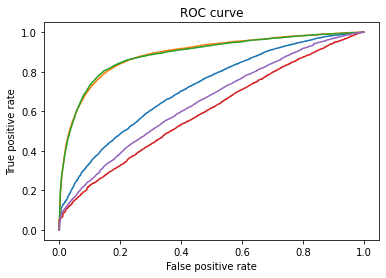

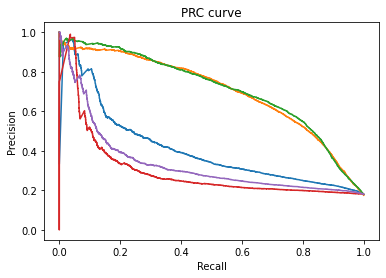

Time taken for this model 310.0398168563843
===============Finished===============
==========Starting for h = 2==========
========Cross Validation: 1/5========
Epoch 1/100
23/23 - 2s - loss: 1.0453 - accuracy: 0.1787 - val_loss: 0.2932 - val_accuracy: 0.1797
Epoch 2/100
23/23 - 1s - loss: 0.4118 - accuracy: 0.1786 - val_loss: 0.3840 - val_accuracy: 0.1797
Epoch 3/100
23/23 - 1s - loss: 0.2761 - accuracy: 0.3208 - val_loss: 0.4039 - val_accuracy: 0.1797
Epoch 4/100
23/23 - 1s - loss: 0.2050 - accuracy: 0.8199 - val_loss: 0.3655 - val_accuracy: 0.1797
Epoch 5/100
23/23 - 1s - loss: 0.1767 - accuracy: 0.8214 - val_loss: 0.3243 - val_accuracy: 0.1797
Epoch 6/100
23/23 - 1s - loss: 0.1682 - accuracy: 0.8214 - val_loss: 0.2875 - val_accuracy: 0.1797
Epoch 7/100
23/23 - 1s - loss: 0.1634 - accuracy: 0.8214 - val_loss: 0.2576 - val_accuracy: 0.1817
Epoch 8/100
23/23 - 1s - loss: 0.1598 - accuracy: 0.8214 - val_loss: 0.2336 - val_accuracy: 0.8203
Epoch 9/100
23/23 - 1s - loss: 0.1570 - accuracy

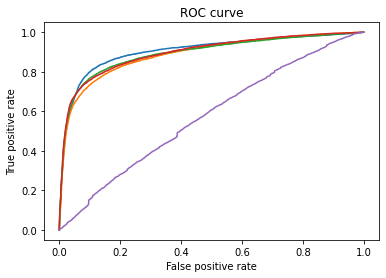

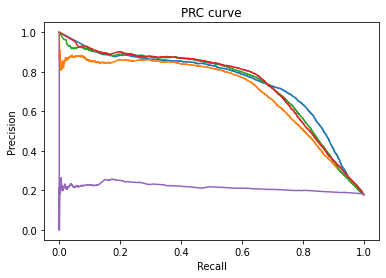

Time taken for this model 576.7999167442322
===============Finished===============
==========Starting for h = 4==========
========Cross Validation: 1/5========
Epoch 1/100
23/23 - 3s - loss: 0.9706 - accuracy: 0.1787 - val_loss: 0.4020 - val_accuracy: 0.1797
Epoch 2/100
23/23 - 2s - loss: 0.3651 - accuracy: 0.1788 - val_loss: 0.4825 - val_accuracy: 0.1797
Epoch 3/100
23/23 - 2s - loss: 0.2569 - accuracy: 0.4447 - val_loss: 0.4486 - val_accuracy: 0.1797
Epoch 4/100
23/23 - 2s - loss: 0.2027 - accuracy: 0.8202 - val_loss: 0.3970 - val_accuracy: 0.1797
Epoch 5/100
23/23 - 2s - loss: 0.1726 - accuracy: 0.8278 - val_loss: 0.3563 - val_accuracy: 0.1797
Epoch 6/100
23/23 - 2s - loss: 0.1550 - accuracy: 0.8325 - val_loss: 0.3288 - val_accuracy: 0.1797
Epoch 7/100
23/23 - 2s - loss: 0.1451 - accuracy: 0.8347 - val_loss: 0.3077 - val_accuracy: 0.1797
Epoch 8/100
23/23 - 2s - loss: 0.1399 - accuracy: 0.8370 - val_loss: 0.2902 - val_accuracy: 0.1797
Epoch 9/100
23/23 - 2s - loss: 0.1345 - accuracy

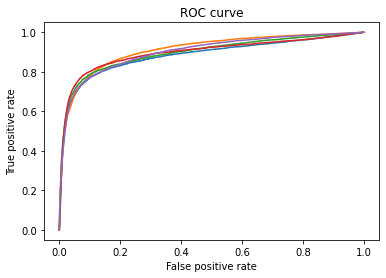

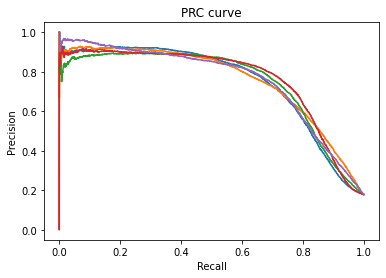

Time taken for this model 685.5851995944977
===============Finished===============
Total time taken 1572.425973892212
The h value for the best validation accuracy is 4 and the corresponding accuracy is 0.905469274520874
The h value for the best auc is 4 and the corresponding auc is 0.8973398475093383


In [4]:
best_h_acc = -1  # best h value when chosen based on the validation accuracy.
best_acc = 0
best_h_auc = -1  # best h value when chosen based on the validation auc value.
best_auc = 0

over_all_start_time = time.time()

for h in [1, 2, 4]:
    start_time = time.time()
    print("==========Starting for h =", str(h) + "==========")

    metrics = k_fold_cross_validation(h, X, Y, k=5, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping_callback])

    print(metrics["model_summary"])

    print("Final metrics for this model")
    print("Average of the final training set accuracy over all folds =", str(metrics["avg_accuracy_train"]))
    print("Average of the final training set loss over all folds =", str(metrics["avg_loss_train"]))
    print("Average of the final validation set accuracy over all folds =", str(metrics["avg_accuracy_val"]))
    print("Average of the final validation set loss over all folds =", str(metrics["avg_loss_val"]))
    print("Average of the ROC AUC over all folds =", str(metrics["avg_roc_auc"]))

    for c in metrics["roc"]: plt.plot(*c)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()

    for c in metrics["prc"]: plt.plot(*c)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PRC curve')
    plt.show()

    if metrics["avg_accuracy_val"] > best_acc:
        best_h_acc = h
        best_acc = metrics["avg_accuracy_val"]

    if metrics["avg_roc_auc"] > best_auc:
        best_h_auc = h
        best_auc = metrics["avg_roc_auc"]

    print("Time taken for this model", str(time.time() - start_time))

    print("===============Finished===============")

print("Total time taken", str(time.time() - over_all_start_time))
print("The h value for the best validation accuracy is", str(best_h_acc), "and the corresponding accuracy is",
      str(best_acc))
print("The h value for the best auc is", str(best_h_auc), "and the corresponding auc is", str(best_auc))

Now training the best model architecture using the whole data

Epoch 1/100
29/29 [==============================] - 3s 89ms/step - loss: 0.7703 - accuracy: 0.1797
Epoch 2/100
29/29 [==============================] - 2s 84ms/step - loss: 0.3014 - accuracy: 0.2327
Epoch 3/100
29/29 [==============================] - 2s 84ms/step - loss: 0.2099 - accuracy: 0.8036
Epoch 4/100
29/29 [==============================] - 2s 83ms/step - loss: 0.1691 - accuracy: 0.8278
Epoch 5/100
29/29 [==============================] - 2s 85ms/step - loss: 0.1505 - accuracy: 0.8301
Epoch 6/100
29/29 [==============================] - 2s 85ms/step - loss: 0.1416 - accuracy: 0.8344
Epoch 7/100
29/29 [==============================] - 2s 85ms/step - loss: 0.1392 - accuracy: 0.8369
Epoch 8/100
29/29 [==============================] - 2s 83ms/step - loss: 0.1346 - accuracy: 0.8394
Epoch 9/100
29/29 [==============================] - 2s 83ms/step - loss: 0.1305 - accuracy: 0.8424
Epoch 10/100
29/29 [==============================] - 2s 83ms/step - loss: 0.1252 - accuracy: 0.8465

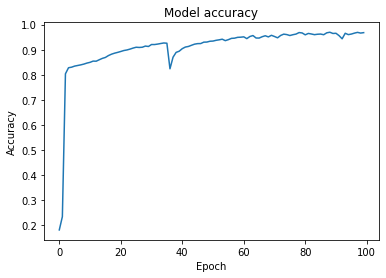

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_80 (Conv1D)           multiple                  1952      
_________________________________________________________________
conv1d_81 (Conv1D)           multiple                  10304     
_________________________________________________________________
batch_normalization_65 (Batc multiple                  256       
_________________________________________________________________
conv1d_82 (Conv1D)           multiple                  20544     
_________________________________________________________________
batch_normalization_66 (Batc multiple                  256       
_________________________________________________________________
conv1d_83 (Conv1D)           multiple                  20544     
_________________________________________________________________
batch_normalization_67 (Batc multiple                

In [5]:
best_h = best_h_auc

model = get_model(best_h)
history = model.fit(X, Y, batch_size=batch_size, epochs=epochs)

plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plot_model(model, to_file='model.png')
model.summary()
model.save("model.h5")